In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [41]:
# Load the data
transaction_data = pd.read_excel(r'/workspaces/quantium/resources/QVI_transaction_data.xlsx')
purchase_behaviour = pd.read_csv(r'/workspaces/quantium/resources/QVI_purchase_behaviour.csv')

In [42]:
# Change the DATE column to datetime format
transaction_data['DATE'] = pd.to_datetime(pd.to_numeric(transaction_data['DATE'], errors='coerce'), unit='D', origin='1899-12-30')

# Remove digits and special characters from PROD_NAME
# df['PROD_NAME'] = df['PROD_NAME'].str.replace('[0-9&]+', '', regex=True)

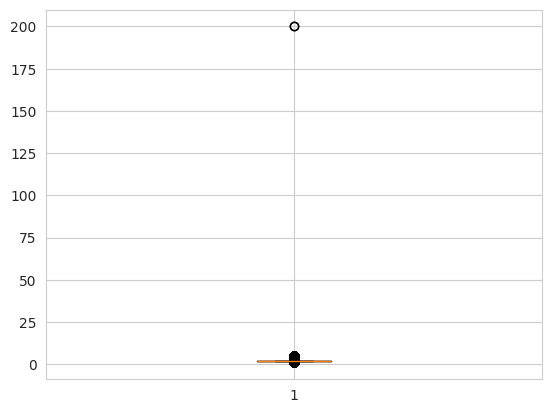

In [43]:
# Find the outliers
plt.boxplot(transaction_data['PROD_QTY'])
plt.show()

# Handle outliers in PROD_QTY column
from scipy import stats

z_scores = stats.zscore(transaction_data['PROD_QTY'])
transaction_data = transaction_data[(z_scores < 3) & (z_scores > -3)]

In [44]:
# Create a new row for December 25th, 2018 with specified values
row_25_dec = {'DATE': '2018-12-25', 'PROD_QTY': 0, 'TOT_SALES': 0}
# Fill other columns with '-'
for col in transaction_data.columns:
    if col not in row_25_dec:
        row_25_dec[col] = '-'

# Append the new row to the dataframe
transaction_data = pd.concat([transaction_data, pd.DataFrame([row_25_dec])], ignore_index=True)

# Sort the dataframe by date to integrate the new row in the correct chronological position
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], errors='coerce')
transaction_data.sort_values(by='DATE', inplace=True)

# Reset index after the sort
transaction_data.reset_index(drop=True, inplace=True)

# Check if the row is added
row_added = transaction_data[transaction_data['DATE'] == '2018-12-25']
print(row_added)

             DATE STORE_NBR LYLTY_CARD_NBR TXN_ID PROD_NBR PROD_NAME  \
128876 2018-12-25         -              -      -        -         -   

        PROD_QTY  TOT_SALES  
128876         0        0.0  


Initial data findings for chips product category transactions

In [45]:
# Filter for 'Chip' or 'Chips' in the product name
chip_data = transaction_data[transaction_data['PROD_NAME'].str.contains('Chip|Chips', case=False, regex=True)]

# Extract year and month from the DATE column
chip_data['YEAR'] = chip_data['DATE'].dt.year
chip_data['MONTH'] = chip_data['DATE'].dt.month

# Group by year and month to get monthly transactions
monthly_transactions = chip_data.groupby(['YEAR', 'MONTH']).size().reset_index(name='TRANSACTIONS')

/tmp/ipykernel_71791/2566225091.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chip_data['YEAR'] = chip_data['DATE'].dt.year
/tmp/ipykernel_71791/2566225091.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chip_data['MONTH'] = chip_data['DATE'].dt.month


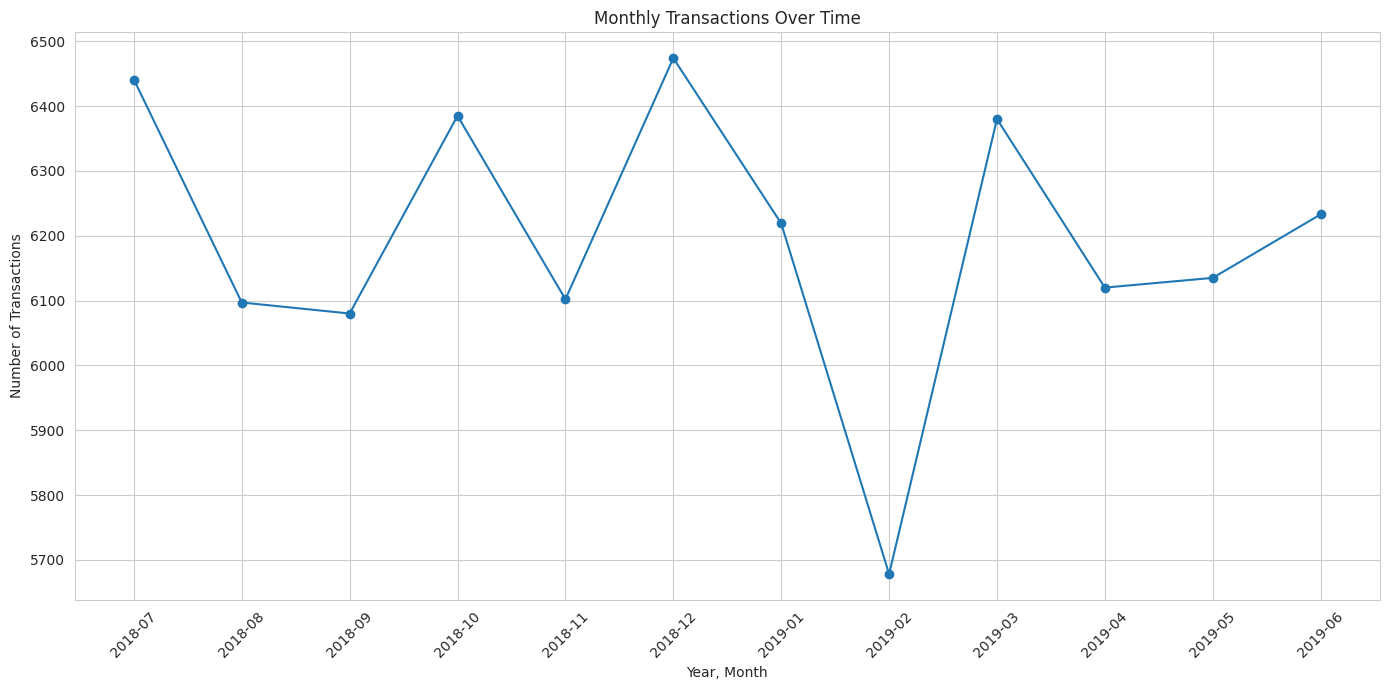

In [46]:
# Plotting the overall transactions over time
monthly_transactions['YEAR_MONTH'] = monthly_transactions['YEAR'].astype(str) + '-' + monthly_transactions['MONTH'].astype(str).str.zfill(2)

# Plotting the overall transactions over time
plt.figure(figsize=(14, 7))
plt.plot(monthly_transactions['YEAR_MONTH'], monthly_transactions['TRANSACTIONS'], marker='o')
plt.xlabel('Year, Month')
plt.ylabel('Number of Transactions')
plt.title('Monthly Transactions Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/workspaces/quantium/output/monthly transactions.png')
plt.show()

/tmp/ipykernel_71791/3835653407.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chip_data['PACK_SIZE'] = chip_data['PROD_NAME'].apply(extract_pack_size)


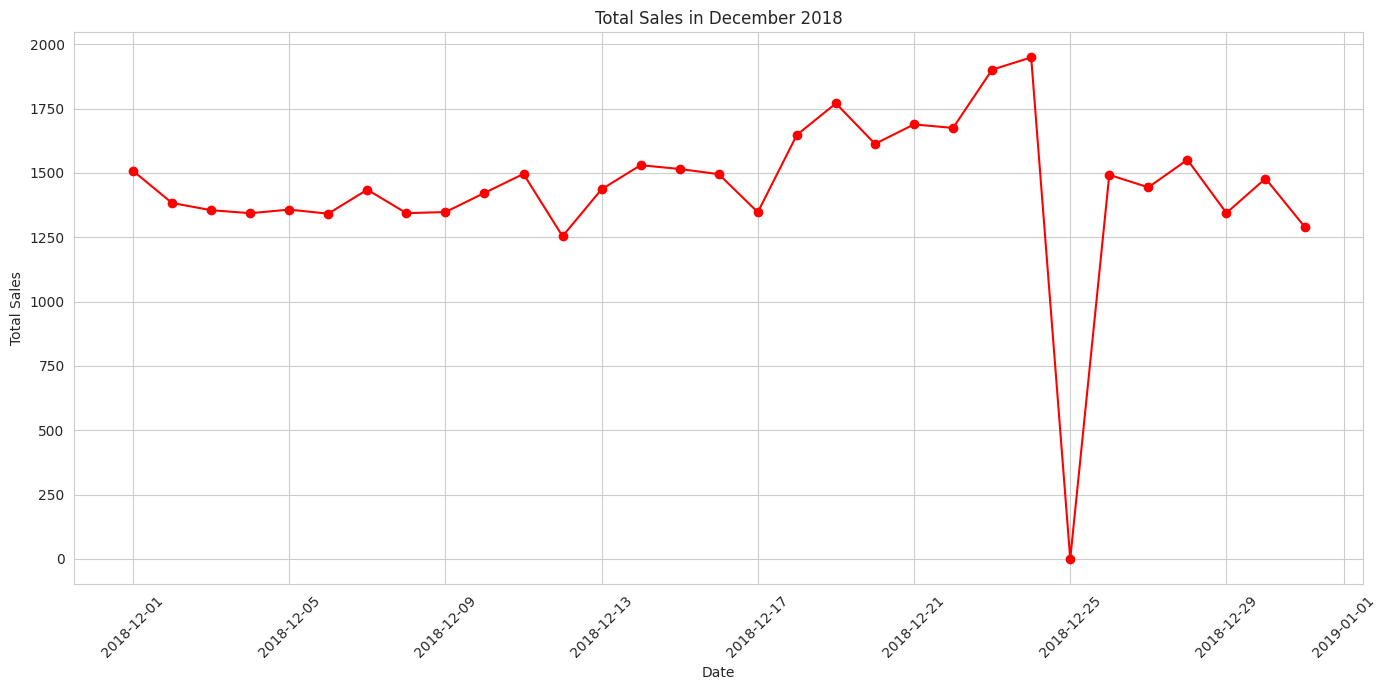

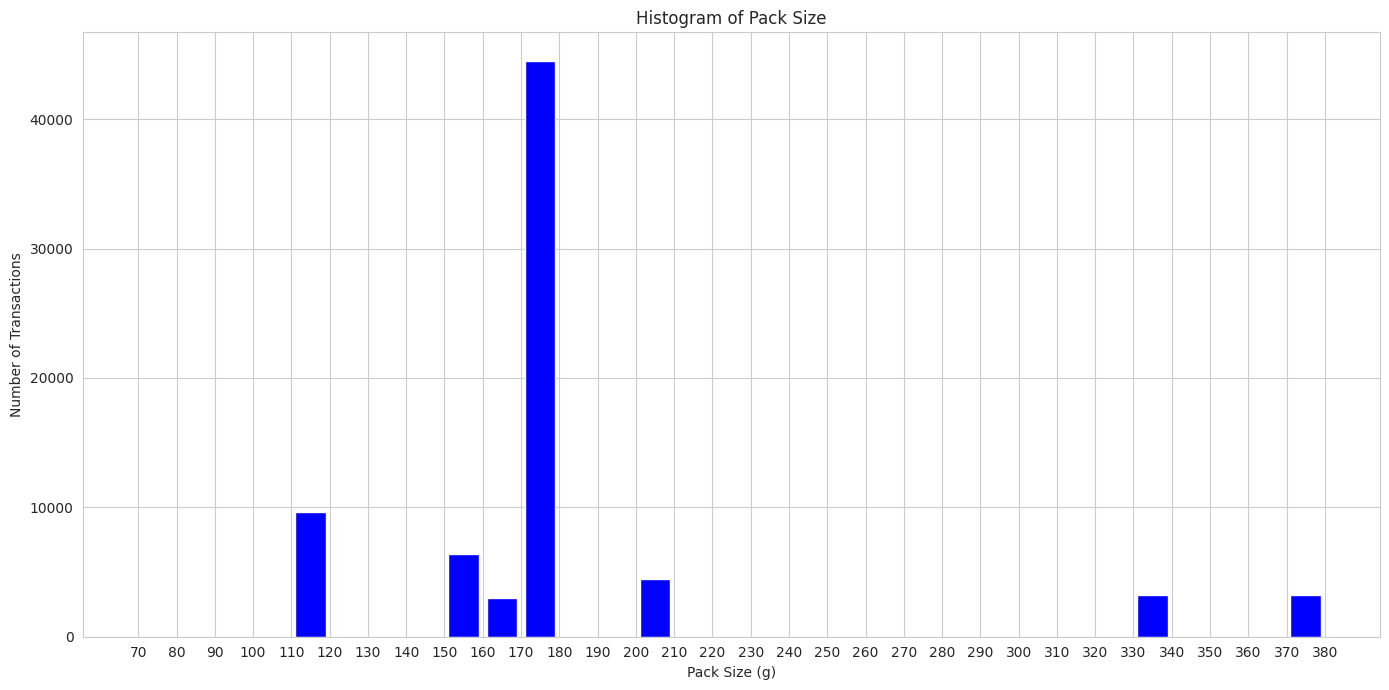

/tmp/ipykernel_71791/3835653407.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chip_data['BRAND'] = chip_data['PROD_NAME'].apply(lambda x: x.split(' ')[0])


(         DATE STORE_NBR LYLTY_CARD_NBR  TXN_ID PROD_NBR  \
 1  2018-07-01        20          20030   16975       90   
 2  2018-07-01       226         226185  227212       40   
 4  2018-07-01       231         231029  233803       28   
 10 2018-07-01       254         254106  254183       44   
 17 2018-07-01       209         209073  207890       96   
 
                                PROD_NAME  PROD_QTY  TOT_SALES  YEAR  MONTH  \
 1      Tostitos Smoked     Chipotle 175g         2        8.8  2018      7   
 2       Thins Chips Seasonedchicken 175g         2        6.6  2018      7   
 4   Thins Potato Chips  Hot & Spicy 175g         2        6.6  2018      7   
 10        Thins Chips Light&  Tangy 175g         1        3.3  2018      7   
 17        WW Original Stacked Chips 160g         2        3.8  2018      7   
 
     PACK_SIZE     BRAND  
 1         175  Tostitos  
 2         175     Thins  
 4         175     Thins  
 10        175     Thins  
 17        160        WW  ,

In [47]:
import re

# Function to extract pack size
def extract_pack_size(product_name):
    match = re.search('(\d+)', product_name)
    return int(match.group(1)) if match else None

# Apply the function to create the 'PACK_SIZE' column
chip_data['PACK_SIZE'] = chip_data['PROD_NAME'].apply(extract_pack_size)

# Filter for December 2018
december_2018_sales = chip_data[(chip_data['YEAR'] == 2018) & (chip_data['MONTH'] == 12)]

# Create a DataFrame with all dates in December 2018 
dates = pd.DataFrame({'DATE': pd.date_range('2018-12-01', '2018-12-31')})

# Merge with the sales data to include missing dates
december_2018_sales = pd.merge(dates, december_2018_sales, how='left', on='DATE')

# Fill missing sales with 0
december_2018_sales['TOT_SALES'] = december_2018_sales['TOT_SALES'].fillna(0)

# Summarize and plot
december_2018_summary = december_2018_sales.groupby('DATE')['TOT_SALES'].sum().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(december_2018_summary['DATE'], december_2018_summary['TOT_SALES'], marker='o', color='red')
plt.title('Total Sales in December 2018') 
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/workspaces/quantium/output/total sales december 2018.png')
plt.show()

# Plot a histogram of PACK_SIZE
plt.figure(figsize=(14, 7))
chip_data['PACK_SIZE'].hist(bins=range(70, 381, 10), color='blue', rwidth=0.8)
plt.title('Histogram of Pack Size')
plt.xlabel('Pack Size (g)')
plt.ylabel('Number of Transactions')
plt.xticks(range(70, 381, 10))
plt.tight_layout()
plt.savefig('/workspaces/quantium/output/pack size histogram.png')
plt.show()

# Create a new column for brand name
chip_data['BRAND'] = chip_data['PROD_NAME'].apply(lambda x: x.split(' ')[0])

(chip_data.head(), december_2018_summary.head())


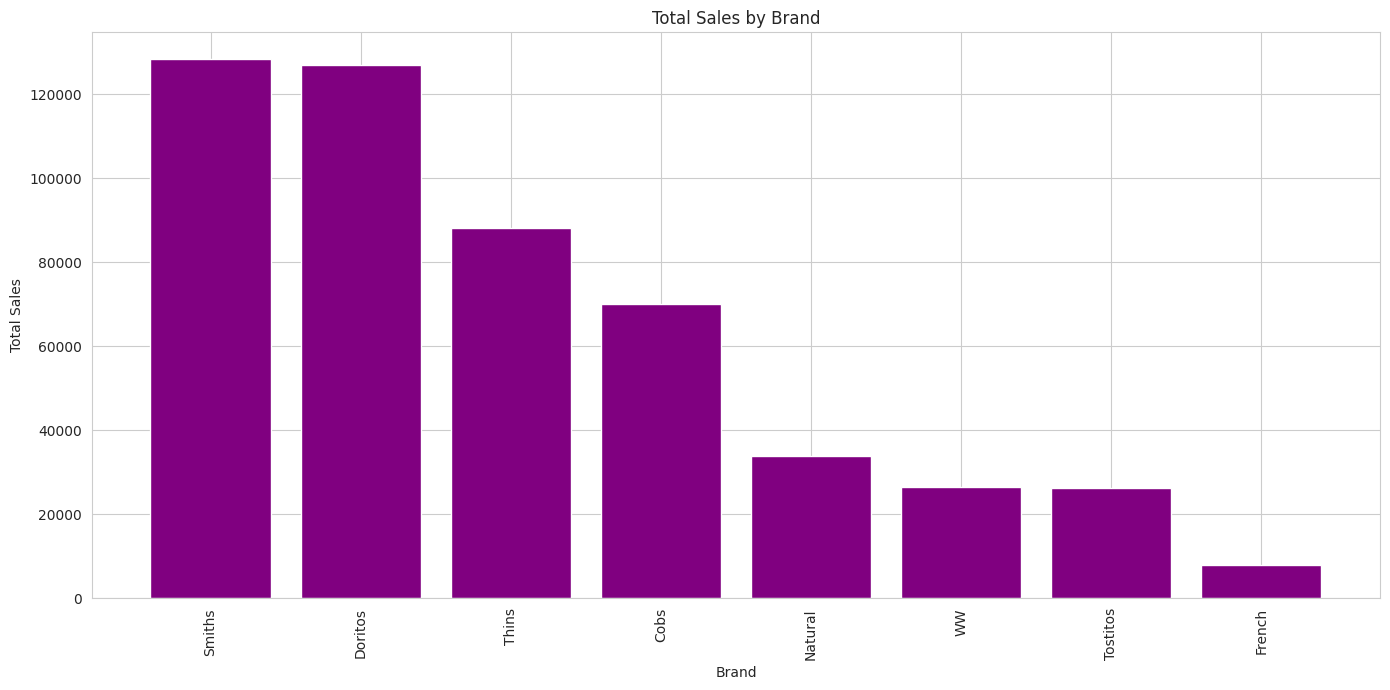

,BRAND,Total_Sales,Transactions
4,Smiths,128263.2,16812
1,Doritos,126844.8,15827
5,Thins,88152.9,14025
0,Cobs,70148.0,9668
3,Natural,33957.0,6027


In [48]:
# Group by brand and summarize total sales and transactions
brand_performance = chip_data.groupby('BRAND').agg(Total_Sales=('TOT_SALES', 'sum'), Transactions=('TXN_ID', 'nunique')).reset_index()

# Sort by total sales
brand_performance_sorted = brand_performance.sort_values(by='Total_Sales', ascending=False)

# Plotting brand performance
plt.figure(figsize=(14, 7))
plt.bar(brand_performance_sorted['BRAND'], brand_performance_sorted['Total_Sales'], color='purple')
plt.title('Total Sales by Brand')
plt.xlabel('Brand')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/workspaces/quantium/output/total sales by brand.png')
plt.show()

# Top 5 Brand by total sales and transaction
brand_performance_sorted.head()

In [49]:
# Continue with customer analysis
# Merge the customer data with the transaction data on the loyalty card number
data_merged = transaction_data.merge(purchase_behaviour, on='LYLTY_CARD_NBR', how='left')

# Check the first few rows of the merged dataframe
merged_head = data_merged.head()

# Check the data types and missing values
customer_info = data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263988 entries, 0 to 263987
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              263988 non-null  datetime64[ns]
 1   STORE_NBR         263988 non-null  object        
 2   LYLTY_CARD_NBR    263988 non-null  object        
 3   TXN_ID            263988 non-null  object        
 4   PROD_NBR          263988 non-null  object        
 5   PROD_NAME         263988 non-null  object        
 6   PROD_QTY          263988 non-null  int64         
 7   TOT_SALES         263988 non-null  float64       
 8   LIFESTAGE         263987 non-null  object        
 9   PREMIUM_CUSTOMER  263987 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 20.1+ MB


In [51]:
# Segment customers based on 'LIFESTAGE' and 'PREMIUM_CUSTOMER' and calculate key metrics
segmented_data = data_merged.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({'TOT_SALES': ['sum', 'mean'], 'PROD_QTY': 'sum', 'TXN_ID': 'nunique'}).reset_index()
segmented_data.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'TOTAL_SALES', 'AVERAGE_SALES', 'TOTAL_QUANTITY', 'TRANSACTION_COUNT']

# Calculate purchase frequency for each segment
segmented_data['PURCHASE_FREQ'] = segmented_data['TRANSACTION_COUNT'] / data_merged['LYLTY_CARD_NBR'].nunique()

# Identify the top-performing segments in terms of sales and quantity
top_sales_segments = segmented_data.sort_values(by='TOTAL_SALES', ascending=False).head()
top_quantity_segments = segmented_data.sort_values(by='TOTAL_QUANTITY', ascending=False).head()

# Output the top-performing segments for sales and quantity
print(top_sales_segments)
print(top_quantity_segments)

                LIFESTAGE PREMIUM_CUSTOMER  TOTAL_SALES  AVERAGE_SALES  \
6          OLDER FAMILIES           Budget    166834.95       7.231997   
19  YOUNG SINGLES/COUPLES       Mainstream    156827.40       7.536518   
13               RETIREES       Mainstream    154761.65       7.229150   
15         YOUNG FAMILIES           Budget    138194.00       7.253517   
9   OLDER SINGLES/COUPLES           Budget    135770.10       7.398512   

    TOTAL_QUANTITY  TRANSACTION_COUNT  PURCHASE_FREQ  
6            44655              22846       0.314822  
19           38433              20738       0.285773  
13           40255              21305       0.293587  
15           36789              18901       0.260459  
9            34974              18247       0.251447  
                LIFESTAGE PREMIUM_CUSTOMER  TOTAL_SALES  AVERAGE_SALES  \
6          OLDER FAMILIES           Budget    166834.95       7.231997   
13               RETIREES       Mainstream    154761.65       7.229150   
19 

In [52]:
# Filter the transaction data for chip products only
chip_products = data_merged[data_merged['PROD_NAME'].str.contains('(?i)chips', regex=True)]

# Analyze product preferences within the top-performing segments
# We will look at the most popular products and their sales contribution within each segment
chip_preferences = chip_products.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER', 'PROD_NAME']).agg({'TOT_SALES': 'sum', 'PROD_QTY': 'sum'}).reset_index()

# Sort the preferences by total sales within each segment
top_chip_preferences = chip_preferences.sort_values(by=['LIFESTAGE', 'PREMIUM_CUSTOMER', 'TOT_SALES'], ascending=[True, True, False])

# Since the output might be long, we will display the top 5 chip products for the first segment as an example
example_segment = top_chip_preferences[(top_chip_preferences['LIFESTAGE'] == 'OLDER FAMILIES') & (top_chip_preferences['PREMIUM_CUSTOMER'] == 'Budget')].head()
print(example_segment)

          LIFESTAGE PREMIUM_CUSTOMER  \
133  OLDER FAMILIES           Budget   
129  OLDER FAMILIES           Budget   
131  OLDER FAMILIES           Budget   
130  OLDER FAMILIES           Budget   
127  OLDER FAMILIES           Budget   

                                    PROD_NAME  TOT_SALES  PROD_QTY  
133  Smiths Crinkle Chips Salt & Vinegar 330g     3163.5       555  
129   Doritos Corn Chips  Cheese Supreme 170g     2433.2       553  
131         Doritos Corn Chips  Original 170g     2103.2       478  
130     Doritos Corn Chips  Nacho Cheese 170g     2019.6       459  
127    Cobs Popd Sour Crm  &Chives Chips 110g     1979.8       521  


In [53]:
# Now we will extend the analysis to all customer segments
# We will display the top 3 chip products for each customer segment by total sales

# Define a function to get the top products for each segment
def get_top_products(segment_data, num_top_products):
    return segment_data.groupby(['PROD_NAME']).agg({'TOT_SALES': 'sum', 'PROD_QTY': 'sum'}).sort_values(by='TOT_SALES', ascending=False).head(num_top_products)

# Apply the function to each segment and store the results in a dictionary
segment_top_products = {}
for (lifestage, premium), group in chip_preferences.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']):
    segment_top_products[(lifestage, premium)] = get_top_products(group, 3)

# Display the top 3 products for each segment
for segment, top_products in segment_top_products.items():
    print(f'Segment: {segment}\
', top_products, '\
')

Segment: ('MIDAGE SINGLES/COUPLES', 'Budget')                                           TOT_SALES  PROD_QTY
PROD_NAME                                                    
Doritos Corn Chips  Cheese Supreme 170g       602.8       137
Smiths Crinkle Chips Salt & Vinegar 330g      501.6        88
Doritos Corn Chips  Original 170g             470.8       107 
Segment: ('MIDAGE SINGLES/COUPLES', 'Mainstream')                                           TOT_SALES  PROD_QTY
PROD_NAME                                                    
Smiths Crinkle Chips Salt & Vinegar 330g     2103.3       369
Doritos Corn Chips  Nacho Cheese 170g        1491.6       339
Cobs Popd Sour Crm  &Chives Chips 110g       1261.6       332 
Segment: ('MIDAGE SINGLES/COUPLES', 'Premium')                                        TOT_SALES  PROD_QTY
PROD_NAME                                                 
Doritos Corn Chips  Original 170g          822.8       187
Doritos Corn Chips  Nacho Cheese 170g      783.2       178